In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# 先给文件名称重命名一下，数字不满5位的一律补全0，因为届时用ImageFolder读取是按字符串顺序读取的
# 即 3.jpg → 00003.jpg
import os
path = 'data/classify-leaves/images'
file_list = os.listdir(path)
 
for file in file_list:
    front, end = file.split('.') # 取得文件名和后缀
    front = front.zfill(5)  # 文件名补0，5表示补0后名字共5位
    new_name = '.'.join([front, end])
    # print(new_name)
    os.rename(path + '\\' + file, path + '\\' + new_name)

In [6]:
# 读取整个临时数据集
data_images = ImageFolder(root='data/classify-leaves')

In [7]:
train_csv = pd.read_csv('data/classify-leaves/train.csv')
print(len(train_csv))
train_csv
# 显示：

18353


,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera
...,...,...
18348,images/18348.jpg,aesculus_glabra
18349,images/18349.jpg,liquidambar_styraciflua
18350,images/18350.jpg,cedrus_libani
18351,images/18351.jpg,prunus_pensylvanica


In [8]:
# 获取某个元素的索引的方法
# 这个class_to_num即作为类别号到类别名称的映射
class_to_num = train_csv.label.unique()
print(np.where(class_to_num == 'quercus_montana')[0][0])

# 将训练集的label对应成类别号
train_csv['class_num'] = train_csv['label'].apply(lambda x: np.where(class_to_num == x)[0][0])
train_csv
# 显示：

19


,image,label,class_num
0,images/0.jpg,maclura_pomifera,0
1,images/1.jpg,maclura_pomifera,0
2,images/2.jpg,maclura_pomifera,0
3,images/3.jpg,maclura_pomifera,0
4,images/4.jpg,maclura_pomifera,0
...,...,...,...
18348,images/18348.jpg,aesculus_glabra,107
18349,images/18349.jpg,liquidambar_styraciflua,75
18350,images/18350.jpg,cedrus_libani,133
18351,images/18351.jpg,prunus_pensylvanica,73


In [9]:
# 创建数据集对象 —— leaf_dataset
class leaf_dataset(Dataset): # 需要继承Dataset类
    def __init__(self, imgs, labels, train=True, transform=None):
        """
        传入数据集imgs、标签labels。
        imgs多于labels长度的数据自动作为验证集,自动设为“-1”类
        Args:
            imgs (Dataset): 传入整个图片数据集,由ImageFolder读取
            labels (pandas: series): 训练集的标签
            train (True or False):是否载入训练集,False则载入验证集
            transform:传入transform方法, 不设置则默认为 Resize((224, 224)) + ToTensor()
        """
        to_train = len(labels)
        to_valid = len(imgs)

        if len(imgs) > len(labels):  # labels是训练集标签，通常会小于imgs的大小，所以补上验证集的标签
            indices1 = range(to_train)
            imgs_to_train = torch.utils.data.Subset(imgs, indices1)

            indices2 = range(to_train, to_valid)
            imgs_to_valid = torch.utils.data.Subset(imgs, indices2)

            labels_valid = pd.Series([-1]*(len(imgs) - len(labels))) # 为验证集标上-1类，与训练集样式统一

            if train == True:
                self.imgs = imgs_to_train
                self.labels = labels
            else:
                self.imgs = imgs_to_valid
                self.labels = labels_valid

        else:  # labels和imgs等长时没有验证集的问题（若imgs长度小于labels，届时Dataloader会抛弃多出来的labels部分）
            self.imgs = imgs
            self.labels = labels

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ]) # 如果没设定transform，采取默认的转换操作

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data_in = self.imgs[idx][0] # 届时传入一个ImageFolder对象，需要取[0]获取数据，不要标签
        data = self.transform(data_in)
        return data, label

In [10]:
imgs = data_images  # 总数据集
labels = train_csv.class_num  # 训练集标签
print(len(imgs), len(labels))
# 序列不等长，超过labels长度部分作为验证集

27153 18353


18353
torch.Size([3, 224, 224]) tensor(0)


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

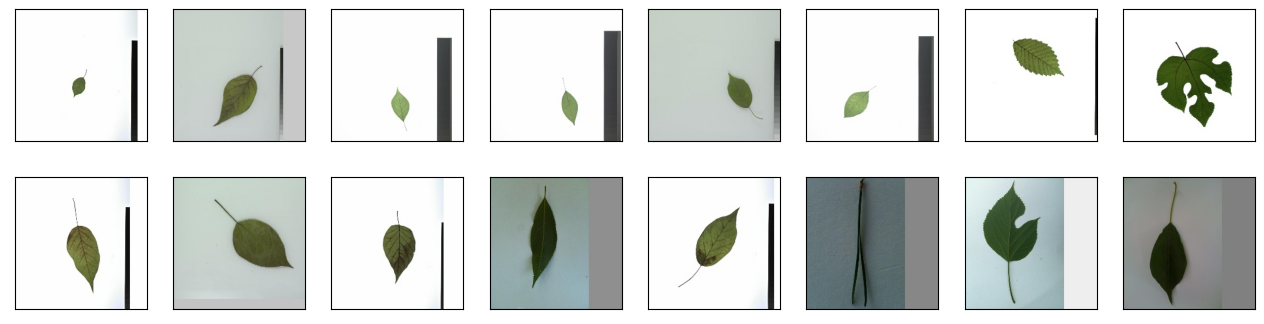

In [11]:
Leaf_dataset_train = leaf_dataset(imgs=imgs, labels=labels, train=True)
print(len(Leaf_dataset_train))

# 传入DataLoader看一下
train_iter = DataLoader(dataset=Leaf_dataset_train, batch_size=128, shuffle=False)
X, y = next(iter(train_iter))
print(X[0].shape, y[0])


# 定义绘图函数 show_images
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

# 展示一下
toshow = [torch.transpose(X[i],0,2) for i in range(16)]
show_images(toshow, 2, 8, scale=2)

8800
torch.Size([3, 224, 224]) tensor(-1)


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

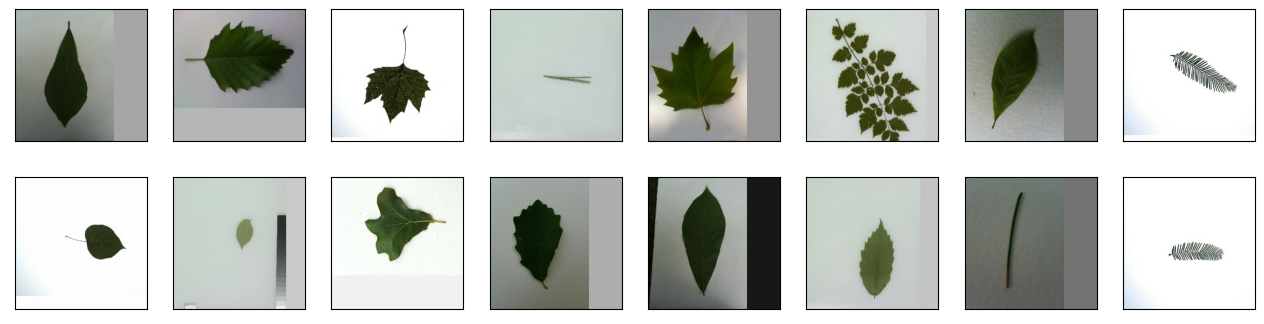

In [12]:
Leaf_dataset_valid = leaf_dataset(imgs=imgs, labels=labels, train=False)
print(len(Leaf_dataset_valid))

# 传入DataLoader看一下
valid_iter = DataLoader(dataset=Leaf_dataset_valid, batch_size=128, shuffle=False)
X, y = next(iter(valid_iter))
print(X[0].shape, y[0])

# 展示一下
toshow = [torch.transpose(X[i],0,2) for i in range(16)]
show_images(toshow, 2, 8, scale=2)

In [13]:
from torchvision import models
pretrained_net = models.resnet34(pretrained=True)
# 使用的torchvision的resnet34预训练模型

# 查看输出层
print(pretrained_net.fc)

# 类别数
print(len(class_to_num))

# 可见此时pretrained_net最后的输出个数等于目标数据集的类别数1000。所以我们应该将最后的fc成修改我们需要的输出类别数 176
pretrained_net.fc = torch.nn.Linear(512, len(class_to_num))
print(pretrained_net.fc)
# 显示：

D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)
176
Linear(in_features=512, out_features=176, bias=True)


In [14]:
# 优化器选取
lr = 0.0001
optimizer = torch.optim.AdamW(pretrained_net.parameters(), lr=lr, weight_decay=0.001)

In [15]:
# 在训练集中分出一部分测试集，以方便第一时间查看训练的效果，测试集数量可以很少。

# 随机拆分，设测试集比率ratio：
def to_split(dataset, ratio=0.1):
    num = len(dataset)
    part1 = int(num * (1 - ratio))
    part2 = num - part1
    train_set, test_set = torch.utils.data.random_split(dataset, [part1, part2])
    return train_set, test_set

train_set, test_set = to_split(Leaf_dataset_train, ratio=0.01) # 测试集比率设0.01
print(len(train_set), len(test_set))
# 显示：

18169 184


In [16]:
# 在leaf_dataset类中已经设置了Resize((224, 224)) + ToTensor()的基础transform方法，这里再设置训练时和测试\验证时所用的图像增广的方法。
# 该方法届时在训练及测试时直接调用。

# Normalize：
# 我们在使用预训练模型时，要和预训练时作同样的预处理。
# 如果你使用的是torchvision的models，那就要求: All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
# The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Dataset中已默认有了 Resize((224, 224)) + ToTensor()，再设RandomHorizontalFlip和预训练模型用的normalize
train_augs = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    normalize
])
# 测试时的增强
test_augs = transforms.Compose([
    normalize
])

In [17]:
# 定义train函数，使用GPU训练并评价模型
import time

# 测试集上评估准确率
def evaluate_accuracy(data_iter, net, device=None):
    """评估模型预测正确率"""
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就用net的device
        device = list(net.parameters())[0].device

    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            # 测试集上做数据增强（normalize）
            X = test_augs(X)
            if isinstance(net, torch.nn.Module):
                net.eval()  # 将模型net调成 评估模式，这会关闭dropout

                # 累加这一个batch数据中判断正确的个数
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()

                net.train()   # 将模型net调回 训练模式
            else:   # 针对自定义的模型（几乎用不到）
                if('is_training' in net.__code__.co_varnames):  # 如果有is_training这个参数
                    # 将 is_training 设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print('training on ', device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            # 训练时使用数据增强
            X = train_augs(X)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
                % (epoch+1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


In [25]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=20):
    train_iter = DataLoader(train_set, batch_size)
    test_iter = DataLoader(test_set, batch_size)
    loss = torch.nn.CrossEntropyLoss()
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)
    
train_fine_tuning(pretrained_net, optimizer)

training on  cuda


D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch 1, loss 2.7830, train acc 0.450, test acc 0.690, time 85.0 sec
epoch 2, loss 0.4159, train acc 0.831, test acc 0.842, time 72.6 sec
epoch 3, loss 0.1257, train acc 0.920, test acc 0.875, time 72.7 sec
epoch 4, loss 0.0525, train acc 0.953, test acc 0.908, time 72.8 sec
epoch 5, loss 0.0277, train acc 0.967, test acc 0.913, time 72.9 sec
epoch 6, loss 0.0198, train acc 0.970, test acc 0.913, time 72.7 sec
epoch 7, loss 0.0126, train acc 0.977, test acc 0.935, time 72.7 sec
epoch 8, loss 0.0095, train acc 0.979, test acc 0.902, time 72.9 sec
epoch 9, loss 0.0071, train acc 0.982, test acc 0.946, time 72.5 sec
epoch 10, loss 0.0061, train acc 0.982, test acc 0.929, time 72.4 sec
epoch 11, loss 0.0054, train acc 0.981, test acc 0.929, time 72.3 sec
epoch 12, loss 0.0044, train acc 0.983, test acc 0.908, time 72.4 sec
epoch 13, loss 0.0033, train acc 0.986, test acc 0.924, time 72.7 sec
epoch 14, loss 0.0031, train acc 0.986, test acc 0.940, time 72.2 sec
epoch 15, loss 0.0029, train 

In [18]:
# pretrained_net 是 torchvision.models.resnet34() 类
path = 'net.pt'
torch.save(pretrained_net.state_dict(), path)

In [19]:
test_csv = pd.read_csv('data/classify-leaves/test.csv')
print(len(test_csv))
test_csv
# 显示：

8800


,image
0,images/18353.jpg
1,images/18354.jpg
2,images/18355.jpg
3,images/18356.jpg
4,images/18357.jpg
...,...
8795,images/27148.jpg
8796,images/27149.jpg
8797,images/27150.jpg
8798,images/27151.jpg


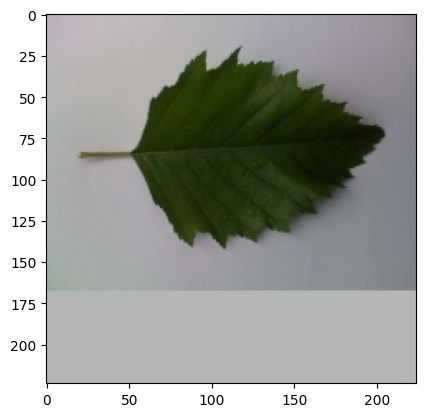

In [20]:
# 查看一下验证集上的第1张图片
X, y = next(iter(valid_iter))
# 查看验证集第1个数据。valid_iter是按原顺序读取的。
plt.imshow(torch.transpose(X[1],0,2))

In [21]:
# 定义预测函数
def valid_output(valid_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就用net的device
        device = list(net.parameters())[0].device

    with torch.no_grad():
        y_output = []
        for X, y in valid_iter:
            # 验证集上做数据增强（normalize）
            X = X.to(device)
            X = test_augs(X)
            net.eval() # 将模型net调成评估模式
            y_hat = net(X).argmax(dim=1)
            y_hat = y_hat.cpu().tolist()
            y_output += y_hat

        return y_output

output = valid_output(valid_iter, pretrained_net)
print(len(output))
# 输出8800

output_label = [class_to_num[i] for i in output]  # 将类别号映射为类别名
test_csv['label'] = output_label
test_csv

8800


,image,label
0,images/18353.jpg,amelanchier_laevis
1,images/18354.jpg,quercus_virginiana
2,images/18355.jpg,malus_pumila
3,images/18356.jpg,platanus_occidentalis
4,images/18357.jpg,amelanchier_laevis
...,...,...
8795,images/27148.jpg,quercus_virginiana
8796,images/27149.jpg,quercus_virginiana
8797,images/27150.jpg,quercus_virginiana
8798,images/27151.jpg,acer_pensylvanicum


In [22]:
test_csv.to_csv('data/classify-leaves/test_pre.csv', index=False)
# 将生成的test.csv上传

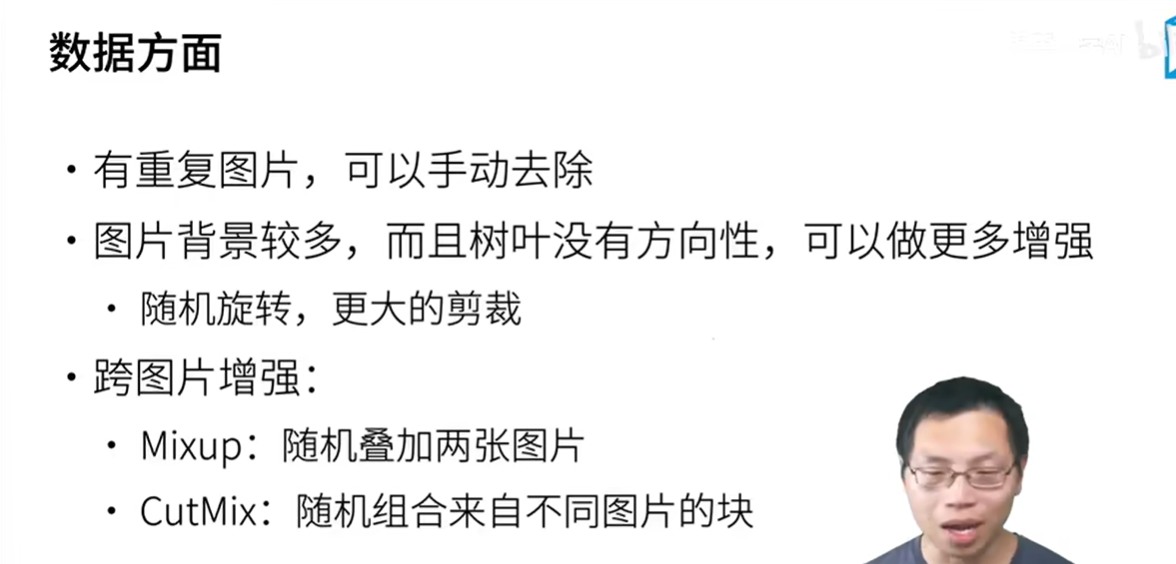
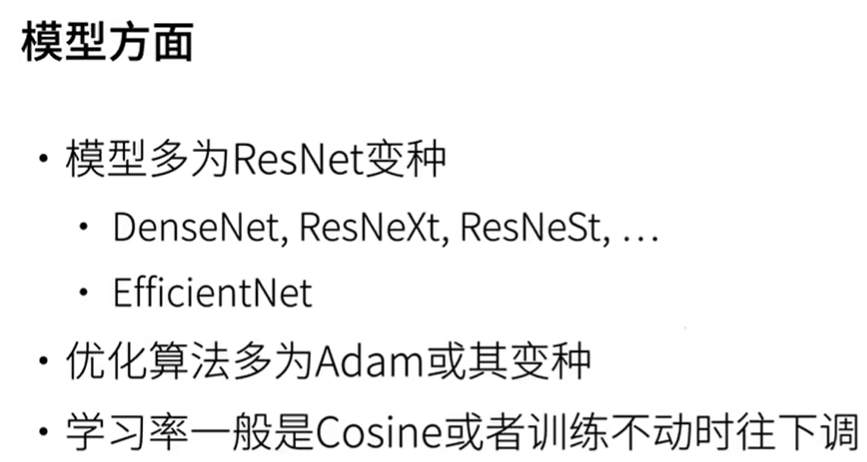
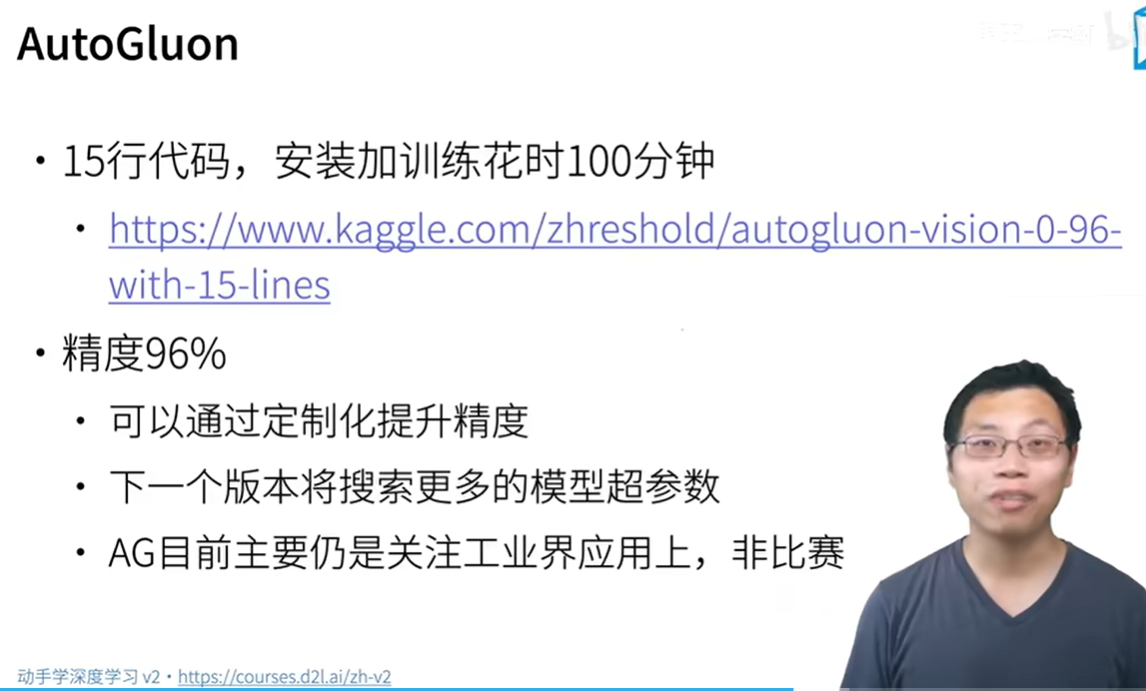
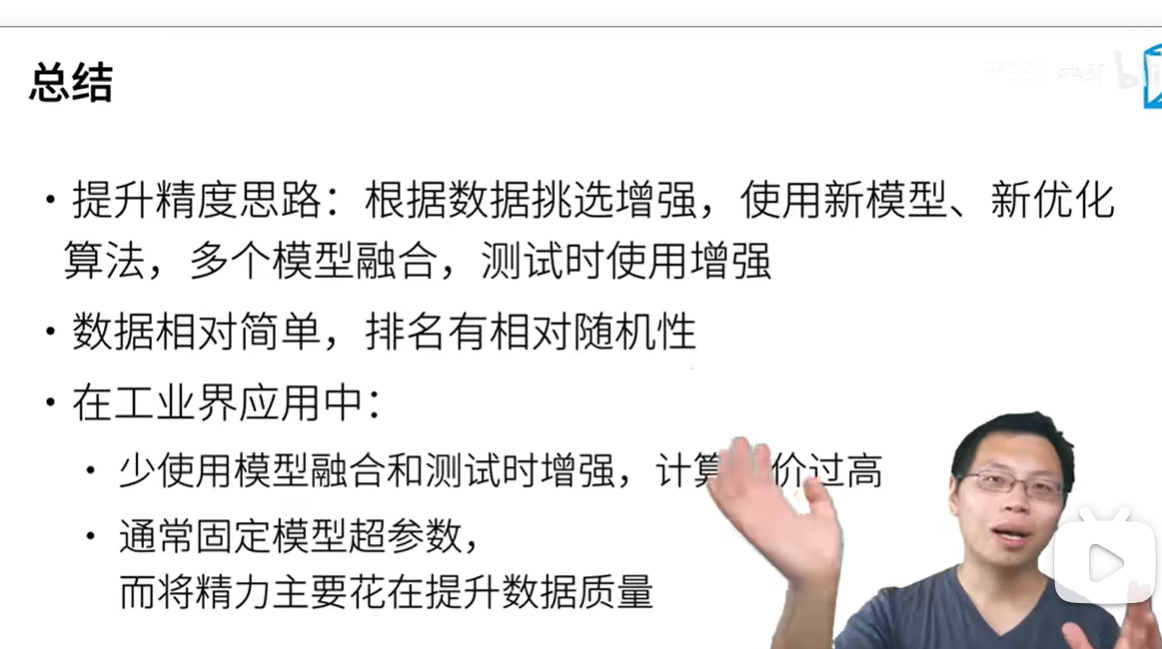